In [1]:
import pandas as pd
import numpy as np
import pymc as pm
#import arviz as az
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Especifica la ruta al archivo CSV
#path = r'C:\\Users\\joset\\OneDrive\\Documentos\\Master Big Data UCM\\18-TFN\NaturgyProject\\data'
# Lee el archivo CSV en un DataFrame de pandas
Emisión_y_Repartos_reducido_original = pd.read_csv('/content/drive/MyDrive/Emisión_y_Repartos_reducido.csv', encoding = 'latin1')
Festivos_Principales_clean_original =  pd.read_csv('/content/drive/MyDrive/Festivos_Principales_clean.csv', encoding = 'latin1')
resultado_temperaturas_diarias_ponderadas_original = pd.read_csv('/content/drive/MyDrive/resultado_temperaturas_diarias_ponderadas.csv', encoding = 'latin1')

In [3]:
Emisión_y_Repartos_reducido = Emisión_y_Repartos_reducido_original
Emisión_y_Repartos_reducido['fecha_gas'] = pd.to_datetime(Emisión_y_Repartos_reducido['fecha_gas'])
Emisión_y_Repartos_reducido[['Reparto_N1', 'Reparto_M3', 'Reparto_M15']] = Emisión_y_Repartos_reducido[['Reparto_N1', 'Reparto_M3', 'Reparto_M15']].fillna(0)
Emisión_y_Repartos_reducido.sort_values(by='fecha_gas', ascending=False).head(3)

,comer,Comercializador,Punto,fecha_gas,Reparto_N1,Reparto_M3,Reparto_M15
847617,33,GNS,H1Z,2024-06-12,2725.0,0.0,0.0
1260100,762,NC,O09,2024-06-12,47.0,0.0,0.0
1480243,52,SUR,S02,2024-06-12,0.0,0.0,0.0


In [4]:
Festivos_Principales_clean = Festivos_Principales_clean_original.copy()
# Renombrar las columnas
Festivos_Principales_clean = Festivos_Principales_clean.rename(columns={'FESTIVO': 'Festivo','DIAS': 'Dias','SEMANA': 'Semana'})
# Mapeo de los días de la semana a formato numérico
dias_a_numeros = {'Monday': 1,'Tuesday': 2,'Wednesday': 3,'Thursday': 4,'Friday': 5,'Saturday': 6,'Sunday': 7}
# Convertir la columna 'Dias' a números utilizando el mapeo
Festivos_Principales_clean['Dias'] = Festivos_Principales_clean['Dias'].map(dias_a_numeros)
# Asegurarte de que las columnas de fechas estén en formato datetime
Festivos_Principales_clean['FECHA'] = pd.to_datetime(Festivos_Principales_clean['FECHA'])
# Filtrar para que solo queden datos desde 2021 en adelante y ordenar
Festivos_Principales_clean = Festivos_Principales_clean[Festivos_Principales_clean['FECHA'].dt.year >= 2021].sort_values(by='FECHA')
# Verificar las primeras filas del DataFrame modificado
Festivos_Principales_clean.head(3)

,FECHA,Festivo,Dias,Semana,Estacion,Horas_Luz
7671,2021-01-01,1,5,53,1,9.34
7672,2021-01-02,0,6,53,1,9.36
7673,2021-01-03,0,7,53,1,9.37


In [5]:
#Hacemos una copia
resultado_temperaturas_diarias_ponderadas = resultado_temperaturas_diarias_ponderadas_original.copy()
# Asegurarte de que las columnas de fechas estén en formato datetime
resultado_temperaturas_diarias_ponderadas['FECHA'] = pd.to_datetime(resultado_temperaturas_diarias_ponderadas['FECHA'])
# Filtrar para que solo queden datos desde 2021 en adelante y ordenar
resultado_temperaturas_diarias_ponderadas = resultado_temperaturas_diarias_ponderadas[resultado_temperaturas_diarias_ponderadas['FECHA'].dt.year >= 2021].sort_values(by='FECHA')
# Verificar las primeras filas del DataFrame modificado
resultado_temperaturas_diarias_ponderadas.head(3).sort_values(by='FECHA')

,FECHA,Temp_Ponderada_MAX,Temp_Ponderada_MIN
0,2021-10-01,25.06,14.28
1,2021-10-02,24.99,14.30
2,2021-10-03,22.50,13.00


In [6]:
# Agrupar por 'fecha_gas' y 'comer', y sumar las columnas 'Reparto_N1', 'Reparto_M3', 'Reparto_M15'
Emisión_y_Repartos_Reparto = Emisión_y_Repartos_reducido[['fecha_gas','comer','Reparto_N1','Reparto_M3','Reparto_M15']]

# Realizar el groupby y sumar las columnas
Emisión_y_Repartos_Reparto = Emisión_y_Repartos_Reparto.groupby(['fecha_gas', 'comer'])[['Reparto_N1','Reparto_M3','Reparto_M15']].sum().reset_index()

# Realizar el merge de los DataFrames con resultado_temperaturas_diarias_ponderadas
Emisión_y_Repartos_Reparto = pd.merge(Emisión_y_Repartos_Reparto,
                                         resultado_temperaturas_diarias_ponderadas,
                                         left_on='fecha_gas',
                                         right_on='FECHA',
                                         how='left')

# Crear una columna 'Fecha' y eliminar las columnas innecesarias
Emisión_y_Repartos_Reparto['Fecha'] = Emisión_y_Repartos_Reparto['fecha_gas']
Emisión_y_Repartos_Reparto = Emisión_y_Repartos_Reparto.drop(columns=['fecha_gas', 'FECHA'])

# Filtrar los datos a partir del 2021-10-01 (incluyendo esa fecha)
fecha_inicio = pd.to_datetime('2021-10-01')
Emisión_y_Repartos_Reparto = Emisión_y_Repartos_Reparto[Emisión_y_Repartos_Reparto['Fecha'] >= fecha_inicio]

# Reordenar las columnas en el DataFrame
new_column_order = ['Fecha', 'comer', 'Reparto_N1','Reparto_M3','Reparto_M15', 'Temp_Ponderada_MAX', 'Temp_Ponderada_MIN']
Emisión_y_Repartos_Reparto = Emisión_y_Repartos_Reparto.reindex(columns=new_column_order)

# Mostrar el DataFrame resultante
Emisión_y_Repartos_Reparto.head(5)

,Fecha,comer,Reparto_N1,Reparto_M3,Reparto_M15,Temp_Ponderada_MAX,Temp_Ponderada_MIN
5844,2021-10-01,33,16511360.0,14233662.0,14233662.0,25.06,14.28
5845,2021-10-01,52,5754009.0,4964015.0,4964015.0,25.06,14.28
5846,2021-10-02,33,14379033.0,13322414.0,13322414.0,24.99,14.30
5847,2021-10-02,52,4752727.0,4590586.0,4590586.0,24.99,14.30
5848,2021-10-03,33,15656470.0,14233333.0,14233333.0,22.50,13.00


#**Vamos a realiazar nuestros Modelo**

# **1: Construcción del modelo bayesiano jerárquico**

In [7]:
# Comercializadora 033
comer_033 = Emisión_y_Repartos_Reparto[Emisión_y_Repartos_Reparto['comer'] == 33]
Reparto_N1_033 = comer_033['Reparto_N1'].values
Reparto_M3_033 = comer_033['Reparto_M3'].values
Reparto_M15_033 = comer_033['Reparto_M15'].values
Temp_ponderada_Max_033 = comer_033['Temp_Ponderada_MAX'].values
Temp_ponderada_Min_033 = comer_033['Temp_Ponderada_MIN'].values

In [8]:
# Comercializadora 052
comer_052 = Emisión_y_Repartos_Reparto[Emisión_y_Repartos_Reparto['comer'] == 52]
Reparto_N1_052 = comer_052['Reparto_N1'].values
Reparto_M3_052 = comer_052['Reparto_M3'].values
Reparto_M15_052 = comer_052['Reparto_M15'].values
Temp_ponderada_Max_052 = comer_052['Temp_Ponderada_MAX'].values
Temp_ponderada_Min_052 = comer_052['Temp_Ponderada_MIN'].values

In [9]:
# Comercializadora 762 (solo Reparto_N1)
comer_762 = Emisión_y_Repartos_Reparto[Emisión_y_Repartos_Reparto['comer'] == 762]
Reparto_N1_762 = comer_762['Reparto_N1'].values
Temp_ponderada_Max_762 = comer_762['Temp_Ponderada_MAX'].values
Temp_ponderada_Min_762 = comer_762['Temp_Ponderada_MIN'].values

In [10]:
with pm.Model() as modelo_bayesiano:
    # Priors globales para los coeficientes de la comercializadora 033
    mu_beta_033_Temp_Max = pm.Normal('mu_beta_033_Temp_Max', mu=0, sigma=10)
    sigma_beta_033_Temp_Max = pm.HalfNormal('sigma_beta_033_Temp_Max', sigma=5)

    # Priors globales para los coeficientes de la comercializadora 052
    mu_beta_052_Temp_Max = pm.Normal('mu_beta_052_Temp_Max', mu=0, sigma=10)
    sigma_beta_052_Temp_Max = pm.HalfNormal('sigma_beta_052_Temp_Max', sigma=5)

    # Priors para los coeficientes de cada target
    beta_033_Temp_Max = pm.Normal('beta_033_Temp_Max', mu=mu_beta_033_Temp_Max, sigma=sigma_beta_033_Temp_Max, shape=3)  # N1, M3, M15
    beta_033_Temp_Min = pm.Normal('beta_033_Temp_Min', mu=0, sigma=10, shape=3)  # N1, M3, M15

    beta_052_Temp_Max = pm.Normal('beta_052_Temp_Max', mu=mu_beta_052_Temp_Max, sigma=sigma_beta_052_Temp_Max, shape=3)  # N1, M3, M15
    beta_052_Temp_Min = pm.Normal('beta_052_Temp_Min', mu=0, sigma=10, shape=3)  # N1, M3, M15

    beta_762_Temp_Max = pm.Normal('beta_762_Temp_Max', mu=0, sigma=10)  # Solo N1
    beta_762_Temp_Min = pm.Normal('beta_762_Temp_Min', mu=0, sigma=10)  # Solo N1

    # Modelos para cada target
    mu_N1_033 = beta_033_Temp_Max[0] * Temp_ponderada_Max_033 + beta_033_Temp_Min[0] * Temp_ponderada_Min_033
    mu_M3_033 = beta_033_Temp_Max[1] * Temp_ponderada_Max_033 + beta_033_Temp_Min[1] * Temp_ponderada_Min_033
    mu_M15_033 = beta_033_Temp_Max[2] * Temp_ponderada_Max_033 + beta_033_Temp_Min[2] * Temp_ponderada_Min_033

    mu_N1_052 = beta_052_Temp_Max[0] * Temp_ponderada_Max_052 + beta_052_Temp_Min[0] * Temp_ponderada_Min_052
    mu_M3_052 = beta_052_Temp_Max[1] * Temp_ponderada_Max_052 + beta_052_Temp_Min[1] * Temp_ponderada_Min_052
    mu_M15_052 = beta_052_Temp_Max[2] * Temp_ponderada_Max_052 + beta_052_Temp_Min[2] * Temp_ponderada_Min_052

    mu_N1_762 = beta_762_Temp_Max * Temp_ponderada_Max_762 + beta_762_Temp_Min * Temp_ponderada_Min_762

    # Likelihoods (distribución observada de los targets)
    sigma_033 = pm.HalfNormal('sigma_033', sigma=1)
    sigma_052 = pm.HalfNormal('sigma_052', sigma=1)
    sigma_762 = pm.HalfNormal('sigma_762', sigma=1)

    y_N1_033 = pm.Normal('y_N1_033', mu=mu_N1_033, sigma=sigma_033, observed=Reparto_N1_033)
    y_M3_033 = pm.Normal('y_M3_033', mu=mu_M3_033, sigma=sigma_033, observed=Reparto_M3_033)
    y_M15_033 = pm.Normal('y_M15_033', mu=mu_M15_033, sigma=sigma_033, observed=Reparto_M15_033)

    y_N1_052 = pm.Normal('y_N1_052', mu=mu_N1_052, sigma=sigma_052, observed=Reparto_N1_052)
    y_M3_052 = pm.Normal('y_M3_052', mu=mu_M3_052, sigma=sigma_052, observed=Reparto_M3_052)
    y_M15_052 = pm.Normal('y_M15_052', mu=mu_M15_052, sigma=sigma_052, observed=Reparto_M15_052)

    y_N1_762 = pm.Normal('y_N1_762', mu=mu_N1_762, sigma=sigma_762, observed=Reparto_N1_762)

    # Realizar el muestreo MCMC
    trace = pm.sample(3000, return_inferencedata=True)

# Mostrar el resumen del modelo
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_033_Temp_Max[0],618848.021,618054.782,176.431,1237000.108,436447.616,369668.399,3.0,11.0,2.23
beta_033_Temp_Max[1],0.385,0.408,-0.023,0.795,0.288,0.244,2.0,24.0,2.73
beta_033_Temp_Max[2],0.492,0.031,0.459,0.523,0.022,0.019,3.0,15.0,2.11
beta_033_Temp_Min[0],-0.528,0.047,-0.600,-0.483,0.033,0.028,3.0,13.0,2.21
beta_033_Temp_Min[1],8696.682,7.408,8684.097,8715.333,1.680,1.207,25.0,49.0,1.84
beta_033_Temp_Min[2],-0.699,0.116,-0.815,-0.582,0.082,0.069,3.0,13.0,2.34
beta_052_Temp_Max[0],348603.677,348633.363,-0.630,697272.335,246192.100,208523.164,3.0,24.0,1.86
beta_052_Temp_Max[1],0.234,0.249,-0.015,0.487,0.176,0.149,3.0,22.0,2.04
beta_052_Temp_Max[2],328343.073,328370.171,0.272,656776.125,231882.977,196403.427,3.0,15.0,2.22
beta_052_Temp_Min[0],4721.196,4720.952,0.630,9441.754,3333.763,2823.676,3.0,14.0,2.17


array([[<Axes: title={'center': 'beta_033_Temp_Max'}>,
        <Axes: title={'center': 'beta_033_Temp_Max'}>],
       [<Axes: title={'center': 'beta_033_Temp_Min'}>,
        <Axes: title={'center': 'beta_033_Temp_Min'}>],
       [<Axes: title={'center': 'beta_052_Temp_Max'}>,
        <Axes: title={'center': 'beta_052_Temp_Max'}>],
       [<Axes: title={'center': 'beta_052_Temp_Min'}>,
        <Axes: title={'center': 'beta_052_Temp_Min'}>],
       [<Axes: title={'center': 'beta_762_Temp_Max'}>,
        <Axes: title={'center': 'beta_762_Temp_Max'}>],
       [<Axes: title={'center': 'beta_762_Temp_Min'}>,
        <Axes: title={'center': 'beta_762_Temp_Min'}>],
       [<Axes: title={'center': 'mu_beta_033_Temp_Max'}>,
        <Axes: title={'center': 'mu_beta_033_Temp_Max'}>],
       [<Axes: title={'center': 'mu_beta_052_Temp_Max'}>,
        <Axes: title={'center': 'mu_beta_052_Temp_Max'}>],
       [<Axes: title={'center': 'sigma_033'}>,
        <Axes: title={'center': 'sigma_033'}>],
     

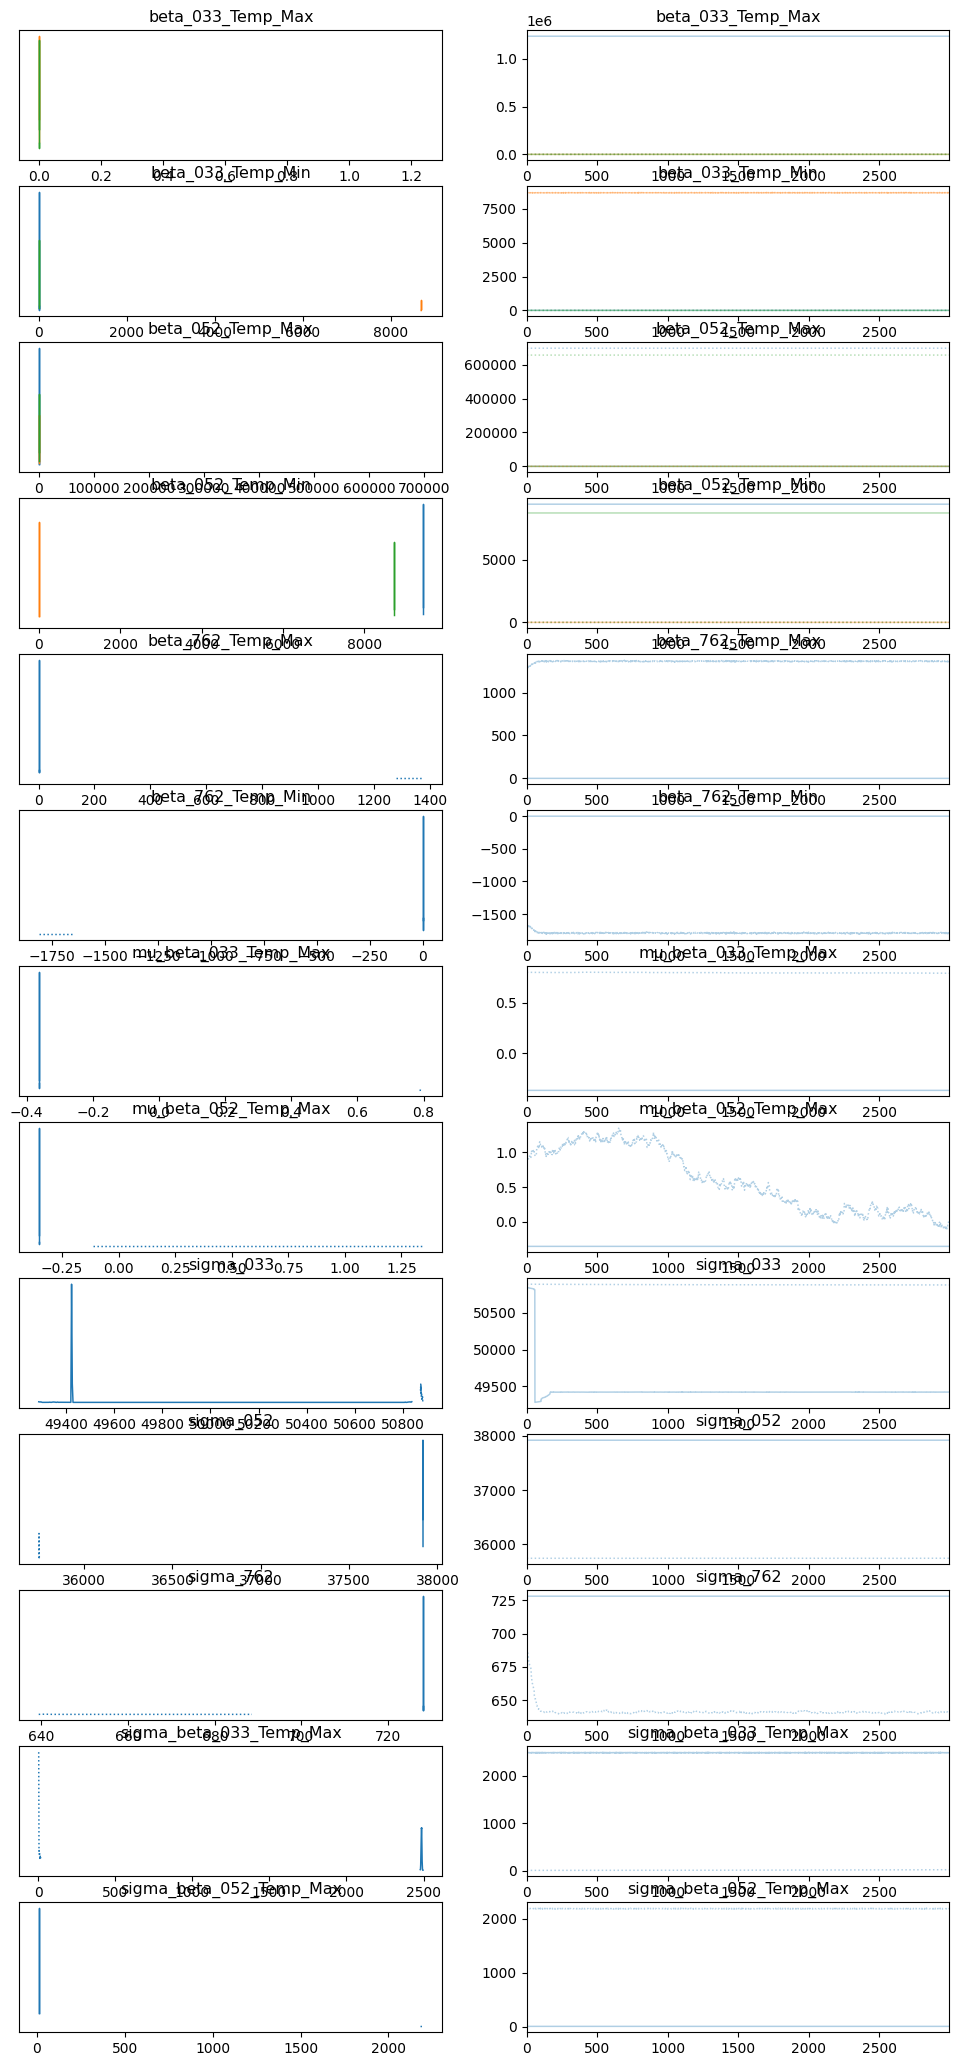

In [11]:
pm.plot_trace(trace)

# **2: Cálculo del "noise" (residuos) y Predicciones**

# **calulos para N1_033:**

In [12]:
# Extraer los parámetros del posterior y calcular la media
beta_temp_max_N1_033 = trace.posterior['beta_033_Temp_Max'].mean().item()  # Extraer la media para N1
beta_temp_min_N1_033 = trace.posterior['beta_033_Temp_Min'].mean().item()  # Extraer la media para N1

# Verificar los valores extraídos
print("beta_temp_max_N1_033:", beta_temp_max_N1_033)
print("beta_temp_min_N1_033:", beta_temp_min_N1_033)

beta_temp_max_N1_033: 206282.96598016846
beta_temp_min_N1_033: 2898.485038463316


In [13]:
# Convertir las variables de Reparto y Temperatura a arrays de NumPy
Reparto_N1_033 = np.array(Reparto_N1_033)
Temp_ponderada_Max_033 = np.array(Temp_ponderada_Max_033)
Temp_ponderada_Min_033 = np.array(Temp_ponderada_Min_033)

# Calcular el noise para N1_033
noise_N1_033 = Reparto_N1_033 - (beta_temp_max_N1_033 * Temp_ponderada_Max_033 + beta_temp_min_N1_033 * Temp_ponderada_Min_033)

# Verificar el resultado del noise
print("Noise N1_033:", noise_N1_033[:10])

Noise N1_033: [11300518.50618772  9182573.34410556 10977422.95994619 14127813.70223616
 14453558.68669394 13338018.41766487 11659111.73763482 11215440.82151556
 10425863.59182488  9835602.61327647]


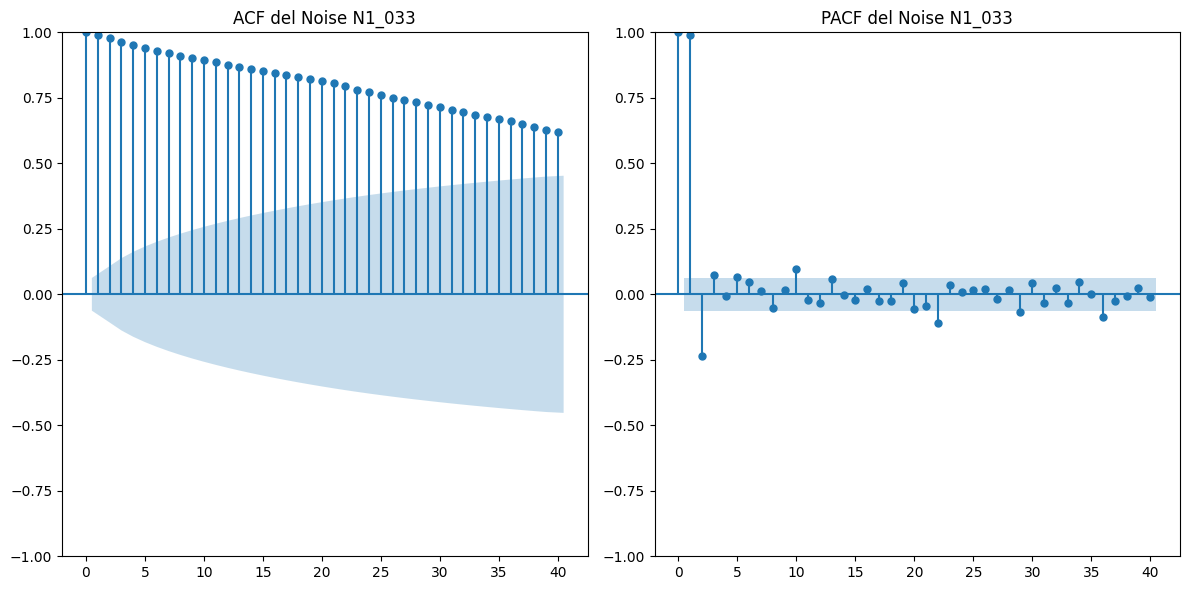

In [14]:
# Plotear los correlogramas ACF y PACF del noise (residuos)
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación del noise
plt.subplot(1, 2, 1)
plot_acf(noise_N1_033, lags=40, ax=plt.gca())
plt.title('ACF del Noise N1_033')

# PACF - Autocorrelación parcial del noise
plt.subplot(1, 2, 2)
plot_pacf(noise_N1_033, lags=40, ax=plt.gca())
plt.title('PACF del Noise N1_033')

plt.tight_layout()
plt.show()

In [15]:
# Aplicar ARIMA sobre el noise de N1_033
model_N1_033_arima = ARIMA(noise_N1_033, order=(2,1,0))  # Ajustar el modelo ARIMA mirar cual Modelo ARIMA aplicar
model_N1_033_fit = model_N1_033_arima.fit()

# Predicciones futuras usando ARIMA
predicciones_arima_N1_033 = model_N1_033_fit.forecast(steps=10)

# Mostrar las predicciones
print(predicciones_arima_N1_033)

[4590961.65249463 4588483.94698315 4589762.36554863 4590311.00176022
 4590346.55973069 4590309.10526614 4590296.19270566 4590295.98457955
 4590297.03191126 4590297.32587466]


In [16]:
# Extraer las medias de los coeficientes para N1 de la comercializadora 033
beta_temp_max_N1_033 = trace.posterior['beta_033_Temp_Max'].mean().item()  # Obtener la media del posterior para Temp_Max
beta_temp_min_N1_033 = trace.posterior['beta_033_Temp_Min'].mean().item()

In [17]:
# Nuevos valores de Temp_Max y Temp_Min para los próximos 10 días
# Generar las fechas para los próximos 10 días
fechas_pred = pd.date_range(start='2024-06-01', periods=10, freq='D')
Temp_ponderada_Max_pred = [30, 32, 31, 29, 28, 30, 29, 31, 32, 30]
Temp_ponderada_Min_pred = [18, 17, 19, 20, 21, 19, 18, 17, 19, 18]

# Realizar predicciones usando los coeficientes extraídos del posterior
predicciones_bayes_N1_033 = beta_temp_max_N1_033 * np.array(Temp_ponderada_Max_pred) + beta_temp_min_N1_033 * np.array(Temp_ponderada_Min_pred)

# Mostrar las predicciones
print(predicciones_bayes_N1_033)


[6240661.71009739 6650329.15701927 6449843.16111603 6040175.71419415
 5836791.23325245 6243560.19513586 6034378.74411723 6444046.1910391
 6656126.12709619 6240661.71009739]


In [18]:
# Sumar la predicción del ARIMA al modelo bayesiano
predicciones_finales_N1_033 = predicciones_bayes_N1_033 + predicciones_arima_N1_033

In [19]:
# Crear un DataFrame con las fechas, temperaturas y predicciones
df_predicciones_N1_033 = pd.DataFrame({
    'Fecha': fechas_pred,
    'Prediccion': predicciones_finales_N1_033,
    'Temp_Ponderada_Max': Temp_ponderada_Max_pred,
    'Temp_Ponderada_Min': Temp_ponderada_Min_pred
})

# Calcular el acumulado de las predicciones
df_predicciones_N1_033['Acumulado'] = df_predicciones_N1_033['Prediccion'].cumsum()

In [20]:
df_predicciones_N1_033.to_excel('/content/drive/MyDrive/GNS_N1.xlsx', index=False)
df_predicciones_N1_033.head(5)

,Fecha,Prediccion,Temp_Ponderada_Max,Temp_Ponderada_Min,Acumulado
0,2024-06-01,1.083162e+07,30,18,1.083162e+07
1,2024-06-02,1.123881e+07,32,17,2.207044e+07
2,2024-06-03,1.103961e+07,31,19,3.311004e+07
3,2024-06-04,1.063049e+07,29,20,4.374053e+07
4,2024-06-05,1.042714e+07,28,21,5.416767e+07


# **calulos para M3_033:**


In [21]:
#Extraer los parámetros del posterior y calcular la media
beta_temp_max_M3_033 = trace.posterior['beta_033_Temp_Max'].mean().item()  # Extraer la media para N1
beta_temp_min_M3_033 = trace.posterior['beta_033_Temp_Min'].mean().item()  # Extraer la media para N1

# Verificar los valores extraídos
print("beta_temp_max_M3_033:", beta_temp_max_M3_033)
print("beta_temp_min_M3_033:", beta_temp_min_M3_033)

beta_temp_max_M3_033: 206282.96598016846
beta_temp_min_M3_033: 2898.485038463316


In [22]:
# Convertir las variables de Reparto y Temperatura a arrays de NumPy
Reparto_M3_033 = np.array(Reparto_M3_033)
Temp_ponderada_Max_033 = np.array(Temp_ponderada_Max_033)
Temp_ponderada_Min_033 = np.array(Temp_ponderada_Min_033)

# Calcular el noise para N1_033
noise_M3_033 = Reparto_M3_033 - (beta_temp_max_M3_033 * Temp_ponderada_Max_033 + beta_temp_min_M3_033 * Temp_ponderada_Min_033)

# Verificar el resultado del noise
print("Noise M3_033:", noise_M3_033[:10])

Noise M3_033: [ 9022820.50618772  8125954.34410556  9554285.95994619 12143829.70223616
 12347249.68669394 11485760.41766487 10525742.73763482 10177757.82151556
  9877299.59182488  9407497.61327647]


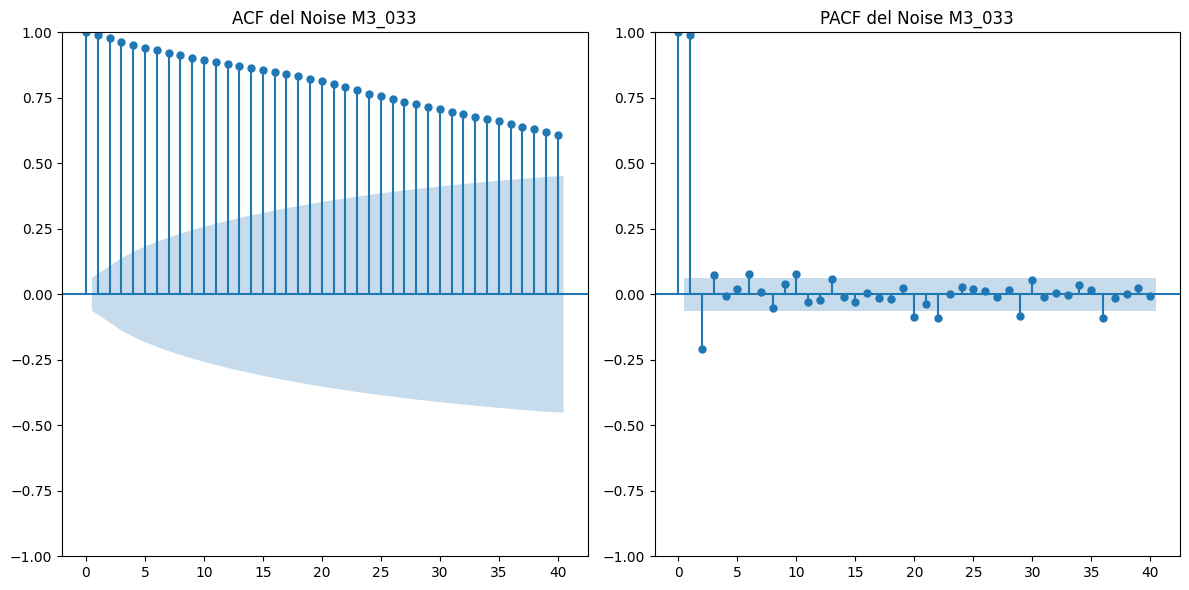

In [23]:
# Plotear los correlogramas ACF y PACF del noise (residuos)
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación del noise
plt.subplot(1, 2, 1)
plot_acf(noise_M3_033, lags=40, ax=plt.gca())
plt.title('ACF del Noise M3_033')

# PACF - Autocorrelación parcial del noise
plt.subplot(1, 2, 2)
plot_pacf(noise_M3_033, lags=40, ax=plt.gca())
plt.title('PACF del Noise M3_033')

plt.tight_layout()
plt.show()

In [24]:
# Aplicar ARIMA sobre el noise de N1_033
model_M3_033_arima = ARIMA(noise_M3_033, order=(2,1,0))  # Ajustar el modelo ARIMA mirar cual Modelo ARIMA aplicar
model_M3_033_fit = model_M3_033_arima.fit()

# Predicciones futuras usando ARIMA
predicciones_arima_M3_033 = model_M3_033_fit.forecast(steps=10)

# Mostrar las predicciones
print(predicciones_arima_M3_033)

[-4689462.02222779 -4684966.49125207 -4686723.2780631  -4687535.72113262
 -4687574.62916886 -4687512.54078715 -4687494.36204729 -4687495.49170009
 -4687497.35653367 -4687497.70072832]


In [25]:
# Extraer las medias de los coeficientes para N1 de la comercializadora 033
beta_temp_max_M3_033 = trace.posterior['beta_033_Temp_Max'].mean().item()  # Obtener la media del posterior para Temp_Max
beta_temp_min_M3_033 = trace.posterior['beta_033_Temp_Min'].mean().item()

In [26]:
# Nuevos valores de Temp_Max y Temp_Min para los próximos 10 días
# Generar las fechas para los próximos 10 días
fechas_pred = pd.date_range(start='2024-06-01', periods=10, freq='D')
Temp_ponderada_Max_pred = [30, 32, 31, 29, 28, 30, 29, 31, 32, 30]
Temp_ponderada_Min_pred = [18, 17, 19, 20, 21, 19, 18, 17, 19, 18]

# Realizar predicciones usando los coeficientes extraídos del posterior
predicciones_bayes_M3_033 = beta_temp_max_M3_033 * np.array(Temp_ponderada_Max_pred) + beta_temp_min_M3_033 * np.array(Temp_ponderada_Min_pred)

# Mostrar las predicciones
print(predicciones_bayes_M3_033)

[6240661.71009739 6650329.15701927 6449843.16111603 6040175.71419415
 5836791.23325245 6243560.19513586 6034378.74411723 6444046.1910391
 6656126.12709619 6240661.71009739]


In [27]:
# Sumar la predicción del ARIMA al modelo bayesiano
predicciones_finales_M3_033 = predicciones_bayes_M3_033 + predicciones_arima_M3_033

In [28]:
# Crear un DataFrame con las fechas, temperaturas y predicciones
df_predicciones_M3_033 = pd.DataFrame({
    'Fecha': fechas_pred,
    'Prediccion': predicciones_finales_M3_033,
    'Temp_Ponderada_Max': Temp_ponderada_Max_pred,
    'Temp_Ponderada_Min': Temp_ponderada_Min_pred
})

# Calcular el acumulado de las predicciones
df_predicciones_M3_033['Acumulado'] = df_predicciones_M3_033['Prediccion'].cumsum()

In [29]:
df_predicciones_M3_033.to_excel('/content/drive/MyDrive/GNS_M3.xlsx', index=False)
df_predicciones_M3_033.head(5)

,Fecha,Prediccion,Temp_Ponderada_Max,Temp_Ponderada_Min,Acumulado
0,2024-06-01,1.551200e+06,30,18,1.551200e+06
1,2024-06-02,1.965363e+06,32,17,3.516562e+06
2,2024-06-03,1.763120e+06,31,19,5.279682e+06
3,2024-06-04,1.352640e+06,29,20,6.632322e+06
4,2024-06-05,1.149217e+06,28,21,7.781539e+06


# **calulos para M15_033:**

In [30]:
#Extraer los parámetros del posterior y calcular la media
beta_temp_max_M15_033 = trace.posterior['beta_033_Temp_Max'].mean().item()  # Extraer la media para N1
beta_temp_min_M15_033 = trace.posterior['beta_033_Temp_Min'].mean().item()  # Extraer la media para N1

# Verificar los valores extraídos
print("beta_temp_max_M3_033:", beta_temp_max_M15_033)
print("beta_temp_min_M15_033:", beta_temp_min_M15_033)

beta_temp_max_M3_033: 206282.96598016846
beta_temp_min_M15_033: 2898.485038463316


In [31]:
# Convertir las variables de Reparto y Temperatura a arrays de NumPy
Reparto_M15_033 = np.array(Reparto_M15_033)
Temp_ponderada_Max_033 = np.array(Temp_ponderada_Max_033)
Temp_ponderada_Min_033 = np.array(Temp_ponderada_Min_033)

# Calcular el noise para N1_033
noise_M15_033 = Reparto_M15_033 - (beta_temp_max_M15_033 * Temp_ponderada_Max_033 + beta_temp_min_M15_033 * Temp_ponderada_Min_033)

# Verificar el resultado del noise
print("Noise M15_033:", noise_M15_033[:10])

Noise M15_033: [ 9022820.50618772  8125954.34410556  9554285.95994619 12143829.70223616
 12347249.68669394 11485760.41766487 10525742.73763482 10177757.82151556
  9877299.59182488  9407497.61327647]


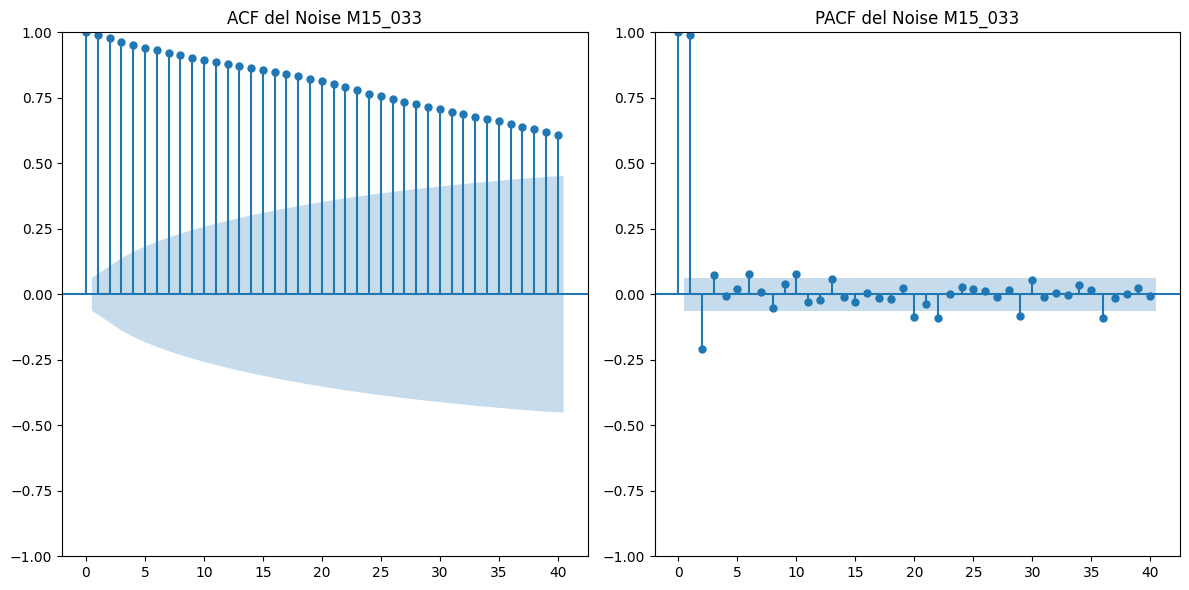

In [32]:
# Plotear los correlogramas ACF y PACF del noise (residuos)
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación del noise
plt.subplot(1, 2, 1)
plot_acf(noise_M15_033, lags=40, ax=plt.gca())
plt.title('ACF del Noise M15_033')

# PACF - Autocorrelación parcial del noise
plt.subplot(1, 2, 2)
plot_pacf(noise_M15_033, lags=40, ax=plt.gca())
plt.title('PACF del Noise M15_033')

plt.tight_layout()
plt.show()

In [33]:
# Aplicar ARIMA sobre el noise de N1_033
model_M15_033_arima = ARIMA(noise_M15_033, order=(2,1,0))  # Ajustar el modelo ARIMA mirar cual Modelo ARIMA aplicar
model_M15_033_fit = model_M15_033_arima.fit()

# Predicciones futuras usando ARIMA
predicciones_arima_M15_033 = model_M15_033_fit.forecast(steps=10)

# Mostrar las predicciones
print(predicciones_arima_M15_033)

[-4689462.02222779 -4684966.49125207 -4686723.2780631  -4687535.72113262
 -4687574.62916886 -4687512.54078715 -4687494.36204729 -4687495.49170009
 -4687497.35653367 -4687497.70072832]


In [34]:
# Extraer las medias de los coeficientes para N1 de la comercializadora 033
beta_temp_max_M15_033 = trace.posterior['beta_033_Temp_Max'].mean().item()  # Obtener la media del posterior para Temp_Max
beta_temp_min_M15_033 = trace.posterior['beta_033_Temp_Min'].mean().item()

In [35]:
# Nuevos valores de Temp_Max y Temp_Min para los próximos 10 días
# Generar las fechas para los próximos 10 días
fechas_pred = pd.date_range(start='2024-06-01', periods=10, freq='D')
Temp_ponderada_Max_pred = [30, 32, 31, 29, 28, 30, 29, 31, 32, 30]
Temp_ponderada_Min_pred = [18, 17, 19, 20, 21, 19, 18, 17, 19, 18]

# Realizar predicciones usando los coeficientes extraídos del posterior
predicciones_bayes_M15_033 = beta_temp_max_M15_033 * np.array(Temp_ponderada_Max_pred) + beta_temp_min_M15_033 * np.array(Temp_ponderada_Min_pred)

# Mostrar las predicciones
print(predicciones_bayes_M15_033)

[6240661.71009739 6650329.15701927 6449843.16111603 6040175.71419415
 5836791.23325245 6243560.19513586 6034378.74411723 6444046.1910391
 6656126.12709619 6240661.71009739]


In [36]:
# Sumar la predicción del ARIMA al modelo bayesiano
predicciones_finales_M15_033 = predicciones_bayes_M15_033 + predicciones_arima_M15_033

In [37]:
# Crear un DataFrame con las fechas, temperaturas y predicciones
df_predicciones_M15_033 = pd.DataFrame({
    'Fecha': fechas_pred,
    'Prediccion': predicciones_finales_M15_033,
    'Temp_Ponderada_Max': Temp_ponderada_Max_pred,
    'Temp_Ponderada_Min': Temp_ponderada_Min_pred
})

# Calcular el acumulado de las predicciones
df_predicciones_M15_033['Acumulado'] = df_predicciones_M15_033['Prediccion'].cumsum()

In [38]:
df_predicciones_M15_033.to_excel('/content/drive/MyDrive/GNS_M15.xlsx', index=False)
df_predicciones_M15_033.head(5)

,Fecha,Prediccion,Temp_Ponderada_Max,Temp_Ponderada_Min,Acumulado
0,2024-06-01,1.551200e+06,30,18,1.551200e+06
1,2024-06-02,1.965363e+06,32,17,3.516562e+06
2,2024-06-03,1.763120e+06,31,19,5.279682e+06
3,2024-06-04,1.352640e+06,29,20,6.632322e+06
4,2024-06-05,1.149217e+06,28,21,7.781539e+06


# **calulos para N1_052:**

In [39]:
# Extraer los parámetros del posterior y calcular la media
beta_temp_max_N1_052 = trace.posterior['beta_052_Temp_Max'].mean().item()  # Extraer la media para N1
beta_temp_min_N1_052 = trace.posterior['beta_052_Temp_Min'].mean().item()  # Extraer la media para N1

# Verificar los valores extraídos
print("beta_temp_max_N1_052:", beta_temp_max_N1_052)
print("beta_temp_min_N1_052:", beta_temp_min_N1_052)

beta_temp_max_N1_052: 225648.9948307669
beta_temp_min_N1_052: 3030.8371752155367


In [40]:
# Convertir las variables de Reparto y Temperatura a arrays de NumPy
Reparto_N1_052 = np.array(Reparto_N1_052)
Temp_ponderada_Max_052 = np.array(Temp_ponderada_Max_052)
Temp_ponderada_Min_052 = np.array(Temp_ponderada_Min_052)

# Calcular el noise para N1_052
noise_N1_052 = Reparto_N1_052 - (beta_temp_max_N1_052 * Temp_ponderada_Max_052 + beta_temp_min_N1_052 * Temp_ponderada_Min_052)

# Verificar el resultado del noise
print("Noise N1_052:", noise_N1_052[:10])

Noise N1_052: [  55964.8346789  -929582.35242645  201621.73302994 1649161.31562927
 1227238.06748808  906199.82600628  -18846.32079766 -150343.89224572
 -229519.40926542 -331190.25950298]


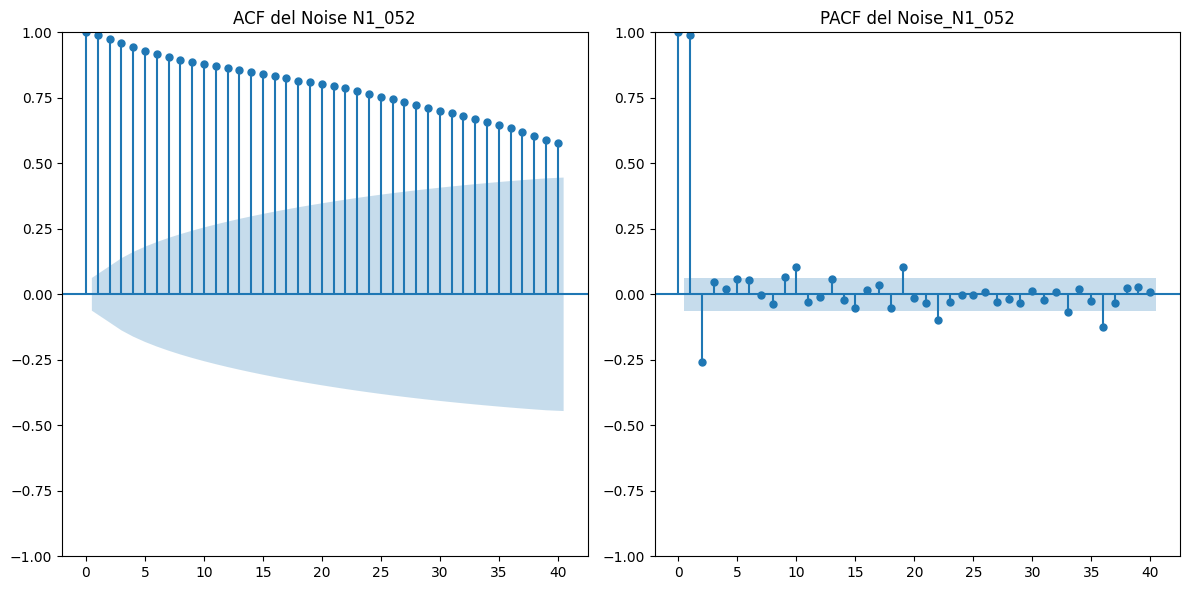

In [41]:
# Plotear los correlogramas ACF y PACF del noise (residuos)
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación del noise
plt.subplot(1, 2, 1)
plot_acf(noise_N1_052, lags=40, ax=plt.gca())
plt.title('ACF del Noise N1_052')

# PACF - Autocorrelación parcial del noise
plt.subplot(1, 2, 2)
plot_pacf(noise_N1_052, lags=40, ax=plt.gca())
plt.title('PACF del Noise_N1_052')

plt.tight_layout()
plt.show()

In [42]:
# Aplicar ARIMA sobre el noise de N1_052
model_N1_052_arima = ARIMA(noise_N1_052, order=(2,1,0))
model_N1_052_fit = model_N1_052_arima.fit()

# Predicciones futuras usando ARIMA
predicciones_arima_N1_052 = model_N1_052_fit.forecast(steps=10)

# Mostrar las predicciones
print(predicciones_arima_N1_052)

[3707439.38183278 3706055.3062852  3707416.37753977 3707885.66233874
 3707935.26250958 3707920.64146483 3707913.48030107 3707912.34812202
 3707912.46513189 3707912.56731871]


In [43]:
# Extraer las medias de los coeficientes para N1 de la comercializadora 052
beta_temp_max_N1_052 = trace.posterior['beta_052_Temp_Max'].mean().item()
beta_temp_min_N1_052 = trace.posterior['beta_052_Temp_Min'].mean().item()

In [44]:
# Nuevos valores de Temp_Max y Temp_Min para los próximos 10 días
# Generar las fechas para los próximos 10 días
fechas_pred = pd.date_range(start='2024-06-01', periods=10, freq='D')
Temp_ponderada_Max_pred = [30, 32, 31, 29, 28, 30, 29, 31, 32, 30]
Temp_ponderada_Min_pred = [18, 17, 19, 20, 21, 19, 18, 17, 19, 18]

# Realizar predicciones usando los coeficientes extraídos del posterior
predicciones_bayes_N1_052 = beta_temp_max_N1_052 * np.array(Temp_ponderada_Max_pred) + beta_temp_min_N1_052 * np.array(Temp_ponderada_Min_pred)

# Mostrar las predicciones
print(predicciones_bayes_N1_052)

[6824024.91407689 7272292.0665632  7052704.74608287 6604437.59359655
 6381819.435941   6827055.7512521  6598375.91924612 7046643.07173244
 7278353.74091364 6824024.91407689]


In [45]:
# Sumar la predicción del ARIMA al modelo bayesiano
predicciones_finales_N1_052 = predicciones_bayes_N1_052 + predicciones_arima_N1_052

In [46]:
# Crear un DataFrame con las fechas, temperaturas y predicciones
df_predicciones_N1_052 = pd.DataFrame({
    'Fecha': fechas_pred,
    'Prediccion': predicciones_finales_N1_052,
    'Temp_Ponderada_Max': Temp_ponderada_Max_pred,
    'Temp_Ponderada_Min': Temp_ponderada_Min_pred
})

# Calcular el acumulado de las predicciones
df_predicciones_N1_052['Acumulado'] = df_predicciones_N1_052['Prediccion'].cumsum()

In [47]:
df_predicciones_N1_052.to_excel('/content/drive/MyDrive/SUR_N1.xlsx', index=False)
df_predicciones_N1_052.head(5)

,Fecha,Prediccion,Temp_Ponderada_Max,Temp_Ponderada_Min,Acumulado
0,2024-06-01,1.053146e+07,30,18,1.053146e+07
1,2024-06-02,1.097835e+07,32,17,2.150981e+07
2,2024-06-03,1.076012e+07,31,19,3.226993e+07
3,2024-06-04,1.031232e+07,29,20,4.258226e+07
4,2024-06-05,1.008975e+07,28,21,5.267201e+07


# **calulos para M3_052:**


In [48]:
# Extraer los parámetros del posterior y calcular la media
beta_temp_max_M3_052 = trace.posterior['beta_052_Temp_Max'].mean().item()  # Extraer la media para N1
beta_temp_min_M3_052 = trace.posterior['beta_052_Temp_Min'].mean().item()  # Extraer la media para N1

# Verificar los valores extraídos
print("beta_temp_max_M3_052:", beta_temp_max_M3_052)
print("beta_temp_min_M3_052:", beta_temp_min_M3_052)

beta_temp_max_M3_052: 225648.9948307669
beta_temp_min_M3_052: 3030.8371752155367


In [49]:
# Convertir las variables de Reparto y Temperatura a arrays de NumPy
Reparto_M3_052 = np.array(Reparto_M3_052)
Temp_ponderada_Max_052 = np.array(Temp_ponderada_Max_052)
Temp_ponderada_Min_052 = np.array(Temp_ponderada_Min_052)

# Calcular el noise para N1_052
noise_M3_052 = Reparto_M3_052 - (beta_temp_max_M3_052 * Temp_ponderada_Max_052 + beta_temp_min_M3_052 * Temp_ponderada_Min_052)

# Verificar el resultado del noise
print("Noise M3_052:", noise_M3_052[:10])

Noise M3_052: [ -734029.1653211  -1091723.35242645  -124944.26697006  1171108.31562927
   769099.06748808   543299.82600628   -77292.32079766  -168928.89224572
   -58413.40926542  -164404.25950298]


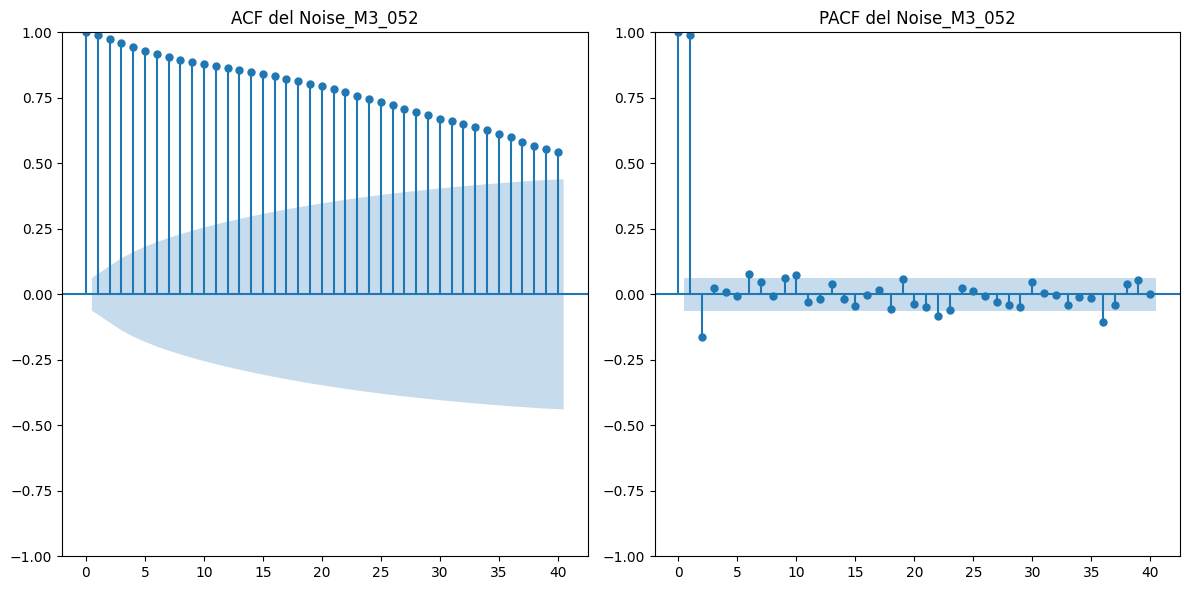

In [50]:
# Plotear los correlogramas ACF y PACF del noise (residuos)
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación del noise
plt.subplot(1, 2, 1)
plot_acf(noise_M3_052, lags=40, ax=plt.gca())
plt.title('ACF del Noise_M3_052')

# PACF - Autocorrelación parcial del noise
plt.subplot(1, 2, 2)
plot_pacf(noise_M3_052, lags=40, ax=plt.gca())
plt.title('PACF del Noise_M3_052')

plt.tight_layout()
plt.show()

In [51]:
# Aplicar ARIMA sobre el noise de M3_052
model_M3_052_arima = ARIMA(noise_M3_052, order=(2,1,0))
model_M3_052_fit = model_M3_052_arima.fit()

# Predicciones futuras usando ARIMA
predicciones_arima_M3_052 = model_M3_052_fit.forecast(steps=10)

# Mostrar las predicciones
print(predicciones_arima_M3_052)

[-5145932.47905315 -5144286.06051469 -5144598.44864969 -5144710.86717475
 -5144719.68022646 -5144717.29634334 -5144716.56962946 -5144716.52540469
 -5144716.54305274 -5144716.54769764]


In [52]:
# Extraer las medias de los coeficientes para N1 de la comercializadora 052
beta_temp_max_M3_052 = trace.posterior['beta_052_Temp_Max'].mean().item()
beta_temp_min_M3_052 = trace.posterior['beta_052_Temp_Min'].mean().item()

In [53]:
# Nuevos valores de Temp_Max y Temp_Min para los próximos 10 días
# Generar las fechas para los próximos 10 días
fechas_pred = pd.date_range(start='2024-06-01', periods=10, freq='D')
Temp_ponderada_Max_pred = [30, 32, 31, 29, 28, 30, 29, 31, 32, 30]
Temp_ponderada_Min_pred = [18, 17, 19, 20, 21, 19, 18, 17, 19, 18]

# Realizar predicciones usando los coeficientes extraídos del posterior
predicciones_bayes_M3_052 = beta_temp_max_M3_052 * np.array(Temp_ponderada_Max_pred) + beta_temp_min_M3_052 * np.array(Temp_ponderada_Min_pred)

# Mostrar las predicciones
print(predicciones_bayes_M3_052)

[6824024.91407689 7272292.0665632  7052704.74608287 6604437.59359655
 6381819.435941   6827055.7512521  6598375.91924612 7046643.07173244
 7278353.74091364 6824024.91407689]


In [54]:
# Sumar la predicción del ARIMA al modelo bayesiano
predicciones_finales_M3_052 = predicciones_bayes_M3_052 + predicciones_arima_M3_052

In [55]:
# Crear un DataFrame con las fechas, temperaturas y predicciones
df_predicciones_M3_052 = pd.DataFrame({
    'Fecha': fechas_pred,
    'Prediccion': predicciones_finales_M3_052,
    'Temp_Ponderada_Max': Temp_ponderada_Max_pred,
    'Temp_Ponderada_Min': Temp_ponderada_Min_pred
})

# Calcular el acumulado de las predicciones
df_predicciones_M3_052['Acumulado'] = df_predicciones_M3_052['Prediccion'].cumsum()

In [56]:
df_predicciones_M3_052.to_excel('/content/drive/MyDrive/SUR_M3.xlsx', index=False)
df_predicciones_M3_052.head(5)

,Fecha,Prediccion,Temp_Ponderada_Max,Temp_Ponderada_Min,Acumulado
0,2024-06-01,1.678092e+06,30,18,1.678092e+06
1,2024-06-02,2.128006e+06,32,17,3.806098e+06
2,2024-06-03,1.908106e+06,31,19,5.714205e+06
3,2024-06-04,1.459727e+06,29,20,7.173931e+06
4,2024-06-05,1.237100e+06,28,21,8.411031e+06


# **calulos para M15_052:**

In [57]:
# Extraer los parámetros del posterior y calcular la media
beta_temp_max_M15_052 = trace.posterior['beta_052_Temp_Max'].mean().item()  # Extraer la media para N1
beta_temp_min_M15_052 = trace.posterior['beta_052_Temp_Min'].mean().item()  # Extraer la media para N1

# Verificar los valores extraídos
print("beta_temp_max_M15_052:", beta_temp_max_M15_052)
print("beta_temp_min_M15_052:", beta_temp_min_M15_052)

beta_temp_max_M15_052: 225648.9948307669
beta_temp_min_M15_052: 3030.8371752155367


In [58]:
# Convertir las variables de Reparto y Temperatura a arrays de NumPy
Reparto_M15_052 = np.array(Reparto_M15_052)
Temp_ponderada_Max_052 = np.array(Temp_ponderada_Max_052)
Temp_ponderada_Min_052 = np.array(Temp_ponderada_Min_052)

# Calcular el noise para N1_033
noise_M15_052 = Reparto_M15_052 - (beta_temp_max_M15_052 * Temp_ponderada_Max_052 + beta_temp_min_M15_052 * Temp_ponderada_Min_052)

# Verificar el resultado del noise
print("Noise M15_052:", noise_M15_052[:10])

Noise M15_052: [ -734029.1653211  -1091723.35242645  -124944.26697006  1171108.31562927
   769099.06748808   543299.82600628   -77292.32079766  -168928.89224572
   -58413.40926542  -164404.25950298]


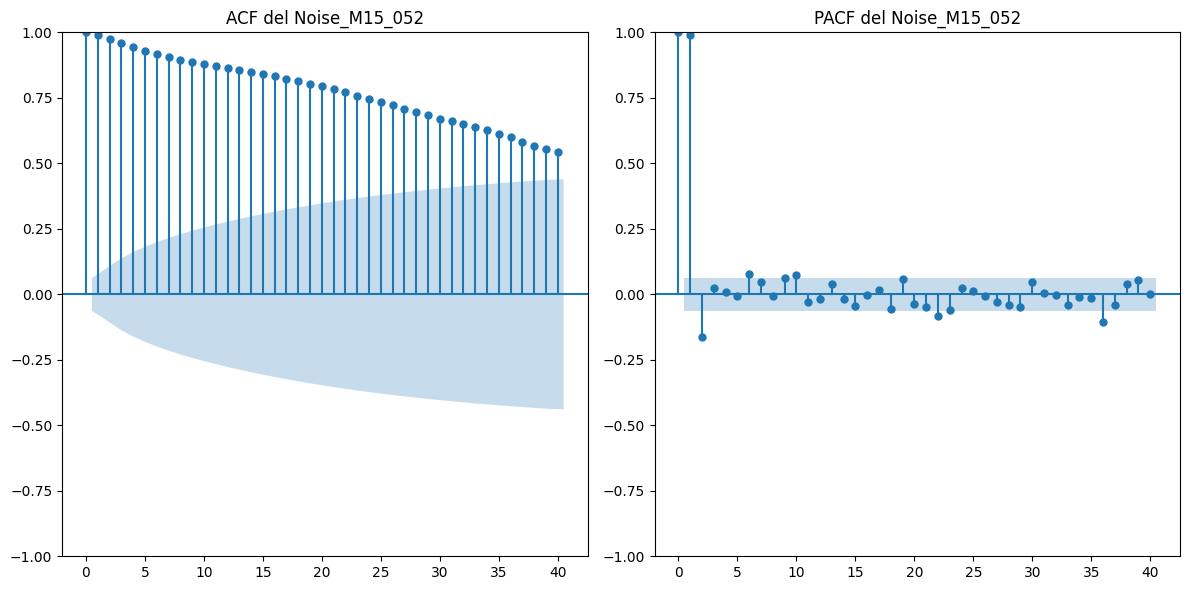

In [59]:
# Plotear los correlogramas ACF y PACF del noise (residuos)
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación del noise
plt.subplot(1, 2, 1)
plot_acf(noise_M15_052, lags=40, ax=plt.gca())
plt.title('ACF del Noise_M15_052')

# PACF - Autocorrelación parcial del noise
plt.subplot(1, 2, 2)
plot_pacf(noise_M15_052, lags=40, ax=plt.gca())
plt.title('PACF del Noise_M15_052')

plt.tight_layout()
plt.show()

In [60]:
# Aplicar ARIMA sobre el noise de N1_033
model_M15_052_arima = ARIMA(noise_M15_052, order=(2,1,0))  # Ajustar el modelo ARIMA mirar cual Modelo ARIMA aplicar
model_M15_052_fit = model_M15_052_arima.fit()

# Predicciones futuras usando ARIMA
predicciones_arima_M15_052 = model_M15_052_fit.forecast(steps=10)

# Mostrar las predicciones
print(predicciones_arima_M15_052)

[-5145932.47905315 -5144286.06051469 -5144598.44864969 -5144710.86717475
 -5144719.68022646 -5144717.29634334 -5144716.56962946 -5144716.52540469
 -5144716.54305274 -5144716.54769764]


In [61]:
# Extraer las medias de los coeficientes para N1 de la comercializadora 052
beta_temp_max_M15_052 = trace.posterior['beta_052_Temp_Max'].mean().item()
beta_temp_min_M15_052 = trace.posterior['beta_052_Temp_Min'].mean().item()

In [62]:
# Nuevos valores de Temp_Max y Temp_Min para los próximos 10 días
# Generar las fechas para los próximos 10 días
fechas_pred = pd.date_range(start='2024-06-01', periods=10, freq='D')
Temp_ponderada_Max_pred = [30, 32, 31, 29, 28, 30, 29, 31, 32, 30]
Temp_ponderada_Min_pred = [18, 17, 19, 20, 21, 19, 18, 17, 19, 18]

# Realizar predicciones usando los coeficientes extraídos del posterior
predicciones_bayes_M15_052 = beta_temp_max_M15_052 * np.array(Temp_ponderada_Max_pred) + beta_temp_min_M15_052 * np.array(Temp_ponderada_Min_pred)

# Mostrar las predicciones
print(predicciones_bayes_M15_052)

[6824024.91407689 7272292.0665632  7052704.74608287 6604437.59359655
 6381819.435941   6827055.7512521  6598375.91924612 7046643.07173244
 7278353.74091364 6824024.91407689]


In [63]:
# Sumar la predicción del ARIMA al modelo bayesiano
predicciones_finales_M15_052 = predicciones_bayes_M15_052 + predicciones_arima_M15_052

In [64]:
# Crear un DataFrame con las fechas, temperaturas y predicciones
df_predicciones_M15_052 = pd.DataFrame({
    'Fecha': fechas_pred,
    'Prediccion': predicciones_finales_M15_052,
    'Temp_Ponderada_Max': Temp_ponderada_Max_pred,
    'Temp_Ponderada_Min': Temp_ponderada_Min_pred
})

# Calcular el acumulado de las predicciones
df_predicciones_M15_052['Acumulado'] = df_predicciones_M15_052['Prediccion'].cumsum()

In [65]:
df_predicciones_M15_052.to_excel('/content/drive/MyDrive/SUR_M15.xlsx', index=False)
df_predicciones_M15_052.head(5)

,Fecha,Prediccion,Temp_Ponderada_Max,Temp_Ponderada_Min,Acumulado
0,2024-06-01,1.678092e+06,30,18,1.678092e+06
1,2024-06-02,2.128006e+06,32,17,3.806098e+06
2,2024-06-03,1.908106e+06,31,19,5.714205e+06
3,2024-06-04,1.459727e+06,29,20,7.173931e+06
4,2024-06-05,1.237100e+06,28,21,8.411031e+06


# **calulos para N1_762:**

In [66]:
# Extraer los parámetros del posterior y calcular la media
beta_temp_max_N1_762 = trace.posterior['beta_762_Temp_Max'].mean().item()  # Extraer la media para N1
beta_temp_min_N1_762 = trace.posterior['beta_762_Temp_Min'].mean().item()  # Extraer la media para N1

# Verificar los valores extraídos
print("beta_temp_max_N1_762:", beta_temp_max_N1_762)
print("beta_temp_min_N1_762:", beta_temp_min_N1_762)

beta_temp_max_N1_762: 681.8979093237472
beta_temp_min_N1_762: -895.0839774148374


In [67]:
# Convertir las variables de Reparto y Temperatura a arrays de NumPy
Reparto_N1_762 = np.array(Reparto_N1_762)
Temp_ponderada_Max_762 = np.array(Temp_ponderada_Max_762)
Temp_ponderada_Min_762 = np.array(Temp_ponderada_Min_762)

# Calcular el noise para N1_052
noise_N1_762 = Reparto_N1_762 - (beta_temp_max_N1_762 * Temp_ponderada_Max_762 + beta_temp_min_N1_762 * Temp_ponderada_Min_762)

# Verificar el resultado del noise
print("Noise N1_762:", noise_N1_762[:10])

Noise N1_762: [-2427.04869213 -4314.55688105 -3608.44053889 -3044.13104734
 -5943.32061701 -6461.63925876 -5918.71039151 -2832.41737188
 -2627.14526067 -6224.23661136]


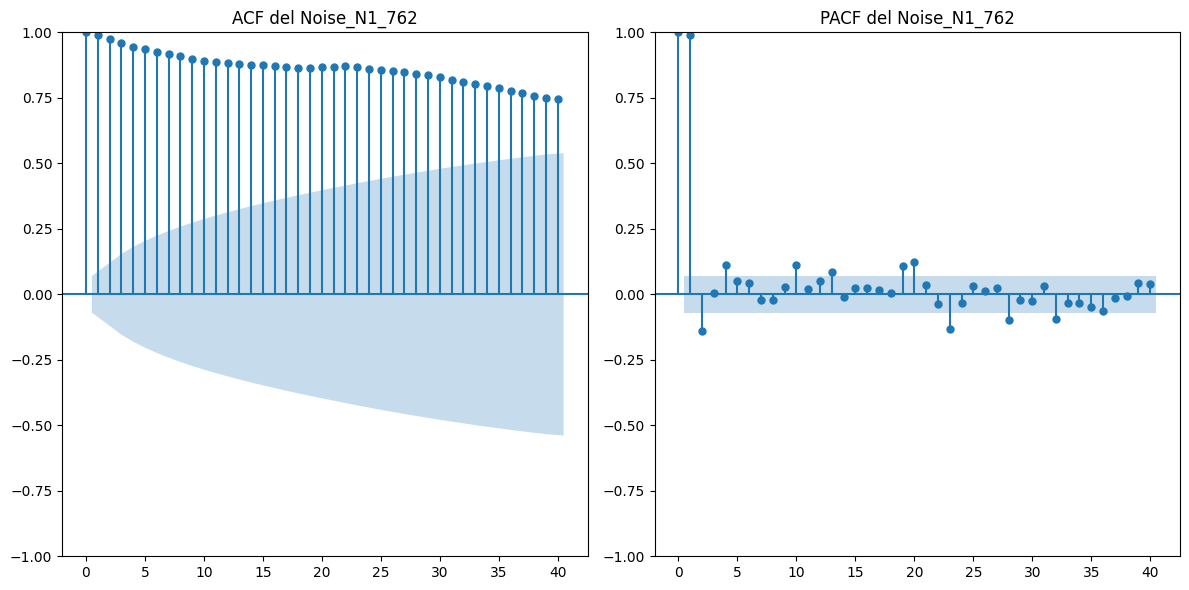

In [68]:
# Plotear los correlogramas ACF y PACF del noise (residuos)
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación del noise
plt.subplot(1, 2, 1)
plot_acf(noise_N1_762, lags=40, ax=plt.gca())
plt.title('ACF del Noise_N1_762')

# PACF - Autocorrelación parcial del noise
plt.subplot(1, 2, 2)
plot_pacf(noise_N1_762, lags=40, ax=plt.gca())
plt.title('PACF del Noise_N1_762')

plt.tight_layout()
plt.show()

In [69]:
# Aplicar ARIMA sobre el noise de N1_052
model_N1_762_arima = ARIMA(noise_N1_762, order=(2,1,0))
model_N1_762_fit = model_N1_762_arima.fit()

# Predicciones futuras usando ARIMA
predicciones_arima_N1_762 = model_N1_762_fit.forecast(steps=10)

# Mostrar las predicciones
print(predicciones_arima_N1_762)

[21140.69215689 21145.74129409 21145.07468832 21144.88912254
 21144.8746363  21144.87590064 21144.87634067 21144.8763807
 21144.87637851 21144.87637748]


In [70]:
# Extraer las medias de los coeficientes para N1 de la comercializadora 762
beta_temp_max_N1_762 = trace.posterior['beta_762_Temp_Max'].mean().item()
beta_temp_min_N1_762 = trace.posterior['beta_762_Temp_Min'].mean().item()

In [71]:
# Nuevos valores de Temp_Max y Temp_Min para los próximos 10 días
# Generar las fechas para los próximos 10 días
fechas_pred = pd.date_range(start='2024-06-01', periods=10, freq='D')
Temp_ponderada_Max_pred = [30, 32, 31, 29, 28, 30, 29, 31, 32, 30]
Temp_ponderada_Min_pred = [18, 17, 19, 20, 21, 19, 18, 17, 19, 18]

# Realizar predicciones usando los coeficientes extraídos del posterior
predicciones_bayes_N1_762 = beta_temp_max_N1_762 * np.array(Temp_ponderada_Max_pred) + beta_temp_min_N1_762 * np.array(Temp_ponderada_Min_pred)

# Mostrar las predicciones
print(predicciones_bayes_N1_762)

[4345.42568625 6604.30548231 4132.23961815 1873.35982209  296.37793535
 3450.34170883 3663.52777692 5922.40757298 4814.13752748 4345.42568625]


In [72]:
# Sumar la predicción del ARIMA al modelo bayesiano
predicciones_finales_N1_762 = predicciones_bayes_N1_762 + predicciones_arima_N1_762

In [73]:
# Crear un DataFrame con las fechas, temperaturas y predicciones
df_predicciones_N1_762 = pd.DataFrame({
    'Fecha': fechas_pred,
    'Prediccion': predicciones_finales_N1_762,
    'Temp_Ponderada_Max': Temp_ponderada_Max_pred,
    'Temp_Ponderada_Min': Temp_ponderada_Min_pred
})

# Calcular el acumulado de las predicciones
df_predicciones_N1_762['Acumulado'] = df_predicciones_N1_762['Prediccion'].cumsum()

In [74]:
df_predicciones_N1_762.to_excel('/content/drive/MyDrive/NC_N1.xlsx', index=False)
df_predicciones_N1_762.head(5)

,Fecha,Prediccion,Temp_Ponderada_Max,Temp_Ponderada_Min,Acumulado
0,2024-06-01,25486.117843,30,18,25486.117843
1,2024-06-02,27750.046776,32,17,53236.164620
2,2024-06-03,25277.314306,31,19,78513.478926
3,2024-06-04,23018.248945,29,20,101531.727871
4,2024-06-05,21441.252572,28,21,122972.980442


#**3-Backtesting:**

In [75]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

MAE N1_033: 2480859.597854922
RMSE N1_033: 4044737.6232241704


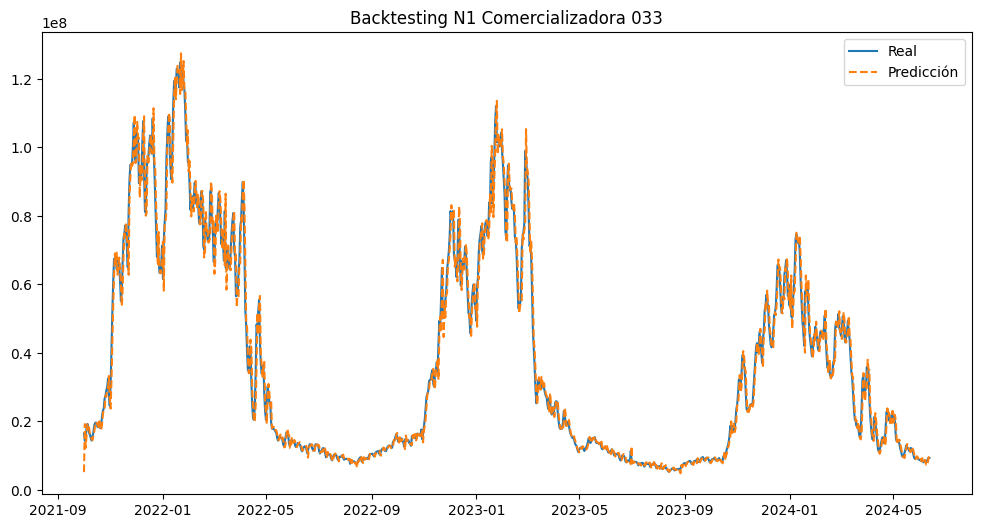

In [76]:
# Datos reales: Reparto_N1_033
reales_N1_033 = np.array(Reparto_N1_033)

# Extraer las medias de los coeficientes del posterior
beta_temp_max_N1_033 = trace.posterior['beta_033_Temp_Max'].mean().item()
beta_temp_min_N1_033 = trace.posterior['beta_033_Temp_Min'].mean().item()

# Realizar predicciones retrospectivas (backtesting)
predicciones_bayes_N1_033 = beta_temp_max_N1_033 * Temp_ponderada_Max_033 + beta_temp_min_N1_033 * Temp_ponderada_Min_033

# Calcular el residual (noise) entre datos reales y predicciones bayesianas
noise_N1_033 = reales_N1_033 - predicciones_bayes_N1_033

# Ajustar modelo ARIMA para el residual (noise)
model_N1_033_arima = ARIMA(noise_N1_033, order=(1,1,1))
model_N1_033_fit = model_N1_033_arima.fit()

# Hacer predicciones usando ARIMA sobre el residual
predicciones_arima_N1_033 = model_N1_033_fit.fittedvalues

# Predicción final combinada
predicciones_finales_N1_033 = predicciones_bayes_N1_033 + predicciones_arima_N1_033

# Calcular métricas de evaluación para el backtesting
mae_N1_033 = mean_absolute_error(reales_N1_033, predicciones_finales_N1_033)
rmse_N1_033 = np.sqrt(mean_squared_error(reales_N1_033, predicciones_finales_N1_033))

print(f"MAE N1_033: {mae_N1_033}")
print(f"RMSE N1_033: {rmse_N1_033}")

# Crear un DataFrame con los resultados
df_backtesting_N1_033 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_N1_033), freq='D'),
    'Real': reales_N1_033,
    'Prediccion': predicciones_finales_N1_033
})

# Plotear los resultados del backtesting
plt.figure(figsize=(12, 6))
plt.plot(df_backtesting_N1_033['Fecha'], df_backtesting_N1_033['Real'], label='Real')
plt.plot(df_backtesting_N1_033['Fecha'], df_backtesting_N1_033['Prediccion'], label='Predicción', linestyle='--')
plt.title('Backtesting N1 Comercializadora 033')
plt.legend()
plt.show()

In [91]:
# Crear un DataFrame con los resultados
df_backtesting_N1_033 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_N1_033), freq='D'),
    'Real': reales_N1_033,
    'Prediccion': predicciones_finales_N1_033
})
df_backtesting_N1_033.head(5)

,Fecha,Real,Prediccion
0,2021-10-01,16511360.0,5.210841e+06
1,2021-10-02,14379033.0,1.923092e+07
2,2021-10-03,15656470.0,1.232509e+07
3,2021-10-04,18127248.0,1.600839e+07
4,2021-10-05,19279748.0,1.941911e+07


MAE M3_033: 2454678.585184693
RMSE M3_033: 4182055.891948939


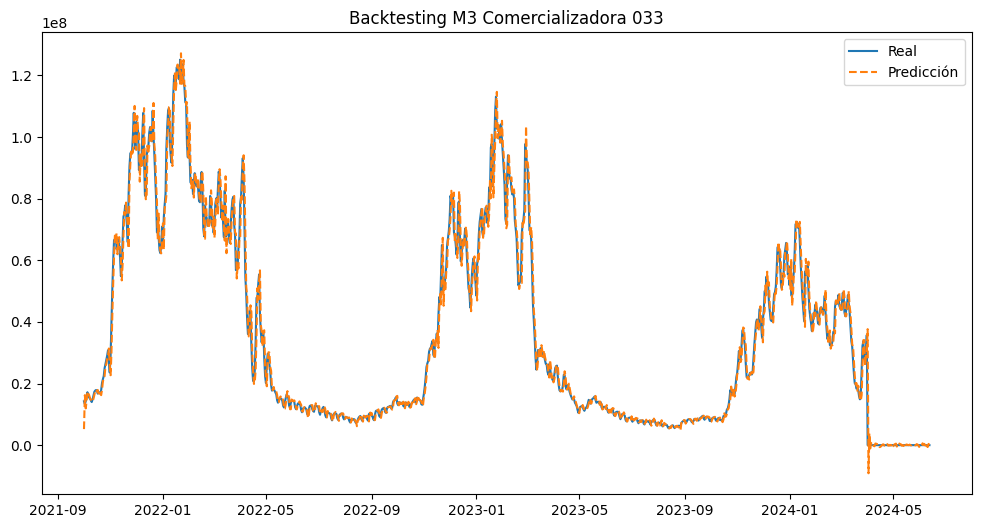

In [77]:
# Datos reales: Reparto_M3_033
reales_M3_033 = np.array(Reparto_M3_033)

# Extraer las medias de los coeficientes del posterior
beta_temp_max_M3_033 = trace.posterior['beta_033_Temp_Max'].mean().item()
beta_temp_min_M3_033 = trace.posterior['beta_033_Temp_Min'].mean().item()

# Realizar predicciones retrospectivas (backtesting)
predicciones_bayes_M3_033 = beta_temp_max_M3_033 * Temp_ponderada_Max_033 + beta_temp_min_M3_033 * Temp_ponderada_Min_033

# Calcular el residual (noise) entre datos reales y predicciones bayesianas
noise_M3_033 = reales_M3_033 - predicciones_bayes_M3_033

# Ajustar modelo ARIMA para el residual (noise)
model_M3_033_arima = ARIMA(noise_M3_033, order=(1,1,1))
model_M3_033_fit = model_M3_033_arima.fit()

# Hacer predicciones usando ARIMA sobre el residual
predicciones_arima_M3_033 = model_M3_033_fit.fittedvalues

# Predicción final combinada
predicciones_finales_M3_033 = predicciones_bayes_M3_033 + predicciones_arima_M3_033

# Calcular métricas de evaluación para el backtesting
mae_M3_033 = mean_absolute_error(reales_M3_033, predicciones_finales_M3_033)
rmse_M3_033 = np.sqrt(mean_squared_error(reales_M3_033, predicciones_finales_M3_033))

print(f"MAE M3_033: {mae_M3_033}")
print(f"RMSE M3_033: {rmse_M3_033}")

# Crear un DataFrame con los resultados
df_backtesting_M3_033 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_M3_033), freq='D'),
    'Real': reales_M3_033,
    'Prediccion': predicciones_finales_M3_033
})

# Plotear los resultados del backtesting
plt.figure(figsize=(12, 6))
plt.plot(df_backtesting_M3_033['Fecha'], df_backtesting_M3_033['Real'], label='Real')
plt.plot(df_backtesting_M3_033['Fecha'], df_backtesting_M3_033['Prediccion'], label='Predicción', linestyle='--')
plt.title('Backtesting M3 Comercializadora 033')
plt.legend()
plt.show()

In [90]:
# Crear un DataFrame con los resultados
df_backtesting_M3_033 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_M3_033), freq='D'),
    'Real': reales_M3_033,
    'Prediccion': predicciones_finales_M3_033
})
df_backtesting_M3_033.head(5)

,Fecha,Real,Prediccion
0,2021-10-01,14233662.0,5.210841e+06
1,2021-10-02,13322414.0,1.621690e+07
2,2021-10-03,14233333.0,1.193349e+07
3,2021-10-04,16143264.0,1.418435e+07
4,2021-10-05,17173439.0,1.738114e+07


MAE M15_033: 2454678.585184693
RMSE M15_033: 4182055.891948939


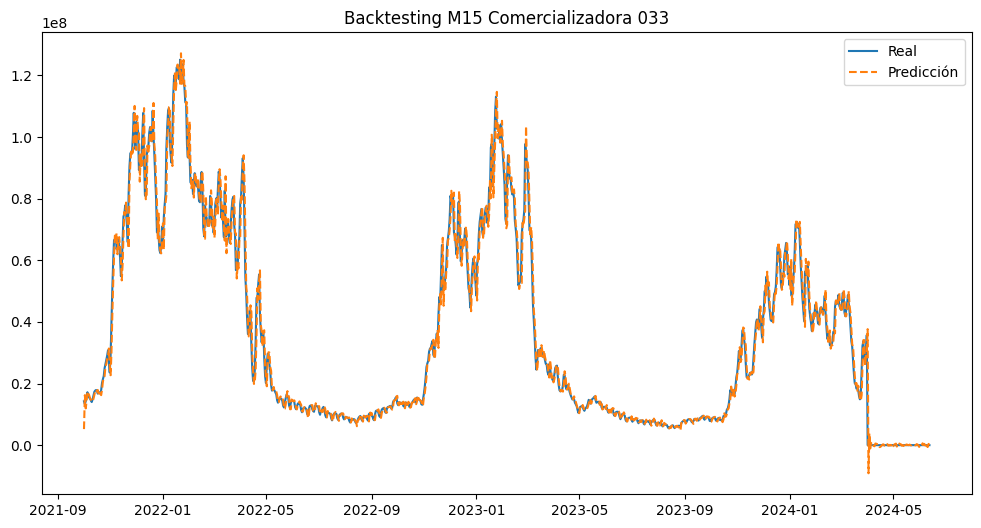

In [78]:
# Datos reales: Reparto_M15_033
reales_M15_033 = np.array(Reparto_M15_033)

# Extraer las medias de los coeficientes del posterior
beta_temp_max_M15_033 = trace.posterior['beta_033_Temp_Max'].mean().item()
beta_temp_min_M15_033 = trace.posterior['beta_033_Temp_Min'].mean().item()

# Realizar predicciones retrospectivas (backtesting)
predicciones_bayes_M15_033 = beta_temp_max_M15_033 * Temp_ponderada_Max_033 + beta_temp_min_M15_033 * Temp_ponderada_Min_033

# Calcular el residual (noise) entre datos reales y predicciones bayesianas
noise_M15_033 = reales_M15_033 - predicciones_bayes_M15_033

# Ajustar modelo ARIMA para el residual (noise)
model_M15_033_arima = ARIMA(noise_M15_033, order=(1,1,1))
model_M15_033_fit = model_M15_033_arima.fit()

# Hacer predicciones usando ARIMA sobre el residual
predicciones_arima_M15_033 = model_M15_033_fit.fittedvalues

# Predicción final combinada
predicciones_finales_M15_033 = predicciones_bayes_M15_033 + predicciones_arima_M15_033

# Calcular métricas de evaluación para el backtesting
mae_M15_033 = mean_absolute_error(reales_M15_033, predicciones_finales_M15_033)
rmse_M15_033 = np.sqrt(mean_squared_error(reales_M15_033, predicciones_finales_M15_033))

print(f"MAE M15_033: {mae_M15_033}")
print(f"RMSE M15_033: {rmse_M15_033}")

# Crear un DataFrame con los resultados
df_backtesting_M15_033 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_M15_033), freq='D'),
    'Real': reales_M15_033,
    'Prediccion': predicciones_finales_M15_033
})

# Plotear los resultados del backtesting
plt.figure(figsize=(12, 6))
plt.plot(df_backtesting_M15_033['Fecha'], df_backtesting_M15_033['Real'], label='Real')
plt.plot(df_backtesting_M15_033['Fecha'], df_backtesting_M15_033['Prediccion'], label='Predicción', linestyle='--')
plt.title('Backtesting M15 Comercializadora 033')
plt.legend()
plt.show()


In [89]:
# Crear un DataFrame con los resultados
df_backtesting_M15_033 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_M15_033), freq='D'),
    'Real': reales_M15_033,
    'Prediccion': predicciones_finales_M15_033
})
df_backtesting_M15_033.head(5)

,Fecha,Real,Prediccion
0,2021-10-01,14233662.0,5.210841e+06
1,2021-10-02,13322414.0,1.621690e+07
2,2021-10-03,14233333.0,1.193349e+07
3,2021-10-04,16143264.0,1.418435e+07
4,2021-10-05,17173439.0,1.738114e+07


MAE N1_052: 1490820.6742716865
RMSE N1_052: 2365242.8764599343


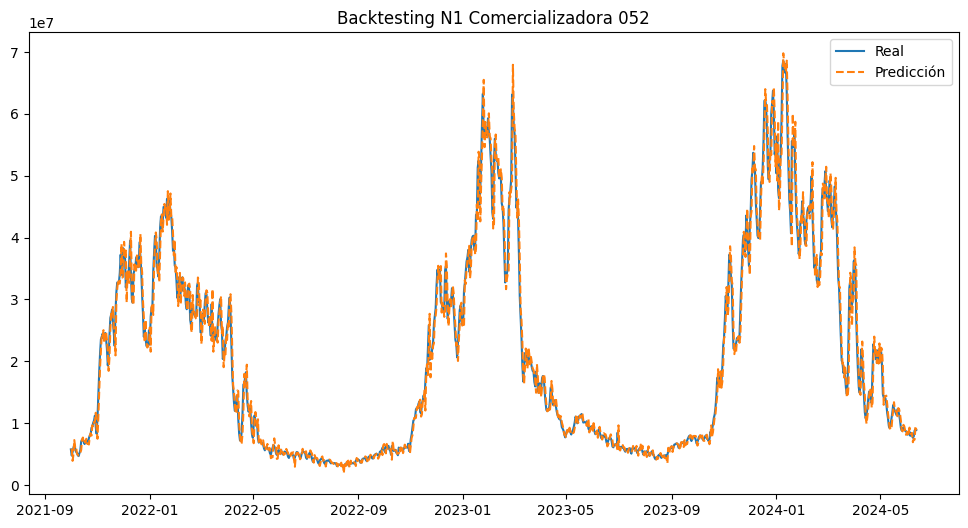

In [79]:
# Datos reales: Reparto_N1_052
reales_N1_052 = np.array(Reparto_N1_052)

# Extraer las medias de los coeficientes del posterior
beta_temp_max_N1_052 = trace.posterior['beta_052_Temp_Max'].mean().item()
beta_temp_min_N1_052 = trace.posterior['beta_052_Temp_Min'].mean().item()

# Realizar predicciones retrospectivas (backtesting)
predicciones_bayes_N1_052 = beta_temp_max_N1_052 * Temp_ponderada_Max_052 + beta_temp_min_N1_052 * Temp_ponderada_Min_052

# Calcular el residual (noise) entre datos reales y predicciones bayesianas
noise_N1_052 = reales_N1_052 - predicciones_bayes_N1_052

# Ajustar modelo ARIMA para el residual (noise)
model_N1_052_arima = ARIMA(noise_N1_052, order=(1,1,1))
model_N1_052_fit = model_N1_052_arima.fit()

# Hacer predicciones usando ARIMA sobre el residual
predicciones_arima_N1_052 = model_N1_052_fit.fittedvalues

# Predicción final combinada
predicciones_finales_N1_052 = predicciones_bayes_N1_052 + predicciones_arima_N1_052

# Calcular métricas de evaluación para el backtesting
mae_N1_052 = mean_absolute_error(reales_N1_052, predicciones_finales_N1_052)
rmse_N1_052 = np.sqrt(mean_squared_error(reales_N1_052, predicciones_finales_N1_052))

print(f"MAE N1_052: {mae_N1_052}")
print(f"RMSE N1_052: {rmse_N1_052}")

# Crear un DataFrame con los resultados
df_backtesting_N1_052 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_N1_052), freq='D'),
    'Real': reales_N1_052,
    'Prediccion': predicciones_finales_N1_052
})

# Plotear los resultados del backtesting
plt.figure(figsize=(12, 6))
plt.plot(df_backtesting_N1_052['Fecha'], df_backtesting_N1_052['Real'], label='Real')
plt.plot(df_backtesting_N1_052['Fecha'], df_backtesting_N1_052['Prediccion'], label='Predicción', linestyle='--')
plt.title('Backtesting N1 Comercializadora 052')
plt.legend()
plt.show()


In [92]:
# Crear un DataFrame con los resultados
df_backtesting_N1_052 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_N1_052), freq='D'),
    'Real': reales_N1_052,
    'Prediccion': predicciones_finales_N1_052
})
df_backtesting_N1_052.head(5)

,Fecha,Real,Prediccion
0,2021-10-01,5754009.0,5.698044e+06
1,2021-10-02,4752727.0,5.753229e+06
2,2021-10-03,5318125.0,3.906992e+06
3,2021-10-04,6022593.0,4.948111e+06
4,2021-10-05,6504963.0,7.261926e+06


MAE M3_052: 1524534.65677304
RMSE M3_052: 2731434.3440692574


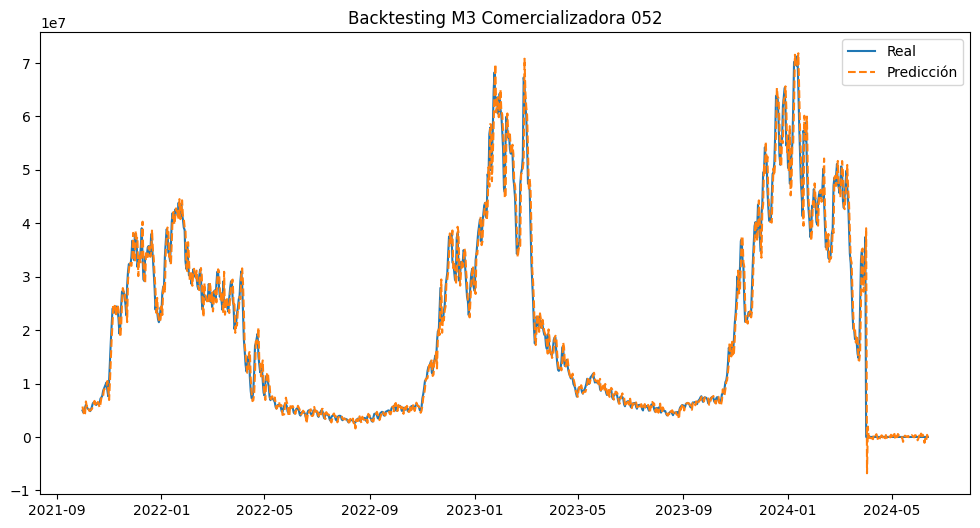

In [80]:
# Datos reales: Reparto_M3_052
reales_M3_052 = np.array(Reparto_M3_052)

# Extraer las medias de los coeficientes del posterior
beta_temp_max_M3_052 = trace.posterior['beta_052_Temp_Max'].mean().item()
beta_temp_min_M3_052 = trace.posterior['beta_052_Temp_Min'].mean().item()

# Realizar predicciones retrospectivas (backtesting)
predicciones_bayes_M3_052 = beta_temp_max_M3_052 * Temp_ponderada_Max_052 + beta_temp_min_M3_052 * Temp_ponderada_Min_052

# Calcular el residual (noise) entre datos reales y predicciones bayesianas
noise_M3_052 = reales_M3_052 - predicciones_bayes_M3_052

# Ajustar modelo ARIMA para el residual (noise)
model_M3_052_arima = ARIMA(noise_M3_052, order=(1,1,1))
model_M3_052_fit = model_M3_052_arima.fit()

# Hacer predicciones usando ARIMA sobre el residual
predicciones_arima_M3_052 = model_M3_052_fit.fittedvalues

# Predicción final combinada
predicciones_finales_M3_052 = predicciones_bayes_M3_052 + predicciones_arima_M3_052

# Calcular métricas de evaluación para el backtesting
mae_M3_052 = mean_absolute_error(reales_M3_052, predicciones_finales_M3_052)
rmse_M3_052 = np.sqrt(mean_squared_error(reales_M3_052, predicciones_finales_M3_052))

print(f"MAE M3_052: {mae_M3_052}")
print(f"RMSE M3_052: {rmse_M3_052}")

# Crear un DataFrame con los resultados
df_backtesting_M3_052 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_M3_052), freq='D'),
    'Real': reales_M3_052,
    'Prediccion': predicciones_finales_M3_052
})

# Plotear los resultados del backtesting
plt.figure(figsize=(12, 6))
plt.plot(df_backtesting_M3_052['Fecha'], df_backtesting_M3_052['Real'], label='Real')
plt.plot(df_backtesting_M3_052['Fecha'], df_backtesting_M3_052['Prediccion'], label='Predicción', linestyle='--')
plt.title('Backtesting M3 Comercializadora 052')
plt.legend()
plt.show()


In [93]:
# Crear un DataFrame con los resultados
df_backtesting_M3_052 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_M3_052), freq='D'),
    'Real': reales_M3_052,
    'Prediccion': predicciones_finales_M3_052
})
df_backtesting_M3_052.head(5)

,Fecha,Real,Prediccion
0,2021-10-01,4964015.0,5.698044e+06
1,2021-10-02,4590586.0,4.823276e+06
2,2021-10-03,4991559.0,3.981901e+06
3,2021-10-04,5544540.0,4.424400e+06
4,2021-10-05,6046824.0,6.647914e+06


MAE M15_052: 1524534.65677304
RMSE M15_052: 2731434.3440692574


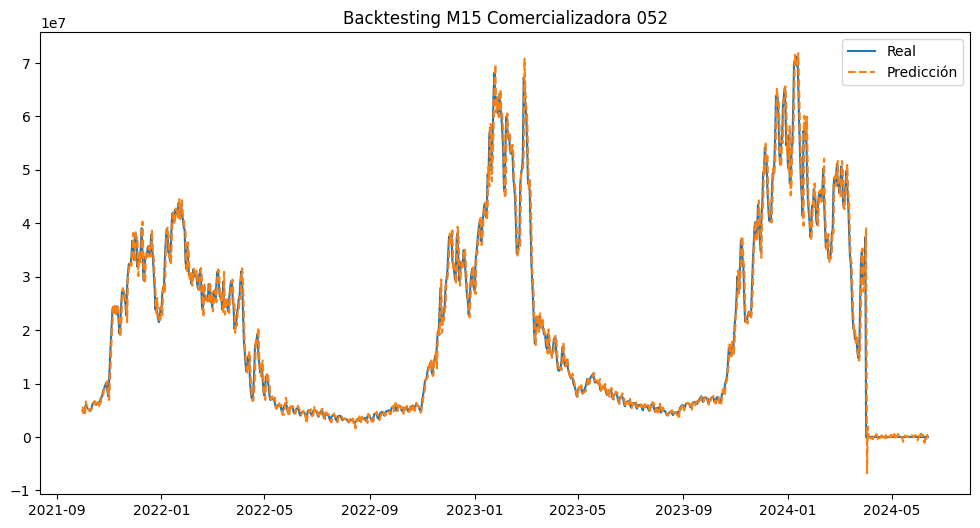

In [81]:
# Datos reales: Reparto_M15_052
reales_M15_052 = np.array(Reparto_M15_052)

# Extraer las medias de los coeficientes del posterior
beta_temp_max_M15_052 = trace.posterior['beta_052_Temp_Max'].mean().item()
beta_temp_min_M15_052 = trace.posterior['beta_052_Temp_Min'].mean().item()

# Realizar predicciones retrospectivas (backtesting)
predicciones_bayes_M15_052 = beta_temp_max_M15_052 * Temp_ponderada_Max_052 + beta_temp_min_M15_052 * Temp_ponderada_Min_052

# Calcular el residual (noise) entre datos reales y predicciones bayesianas
noise_M15_052 = reales_M15_052 - predicciones_bayes_M15_052

# Ajustar modelo ARIMA para el residual (noise)
model_M15_052_arima = ARIMA(noise_M15_052, order=(1,1,1))
model_M15_052_fit = model_M15_052_arima.fit()

# Hacer predicciones usando ARIMA sobre el residual
predicciones_arima_M15_052 = model_M15_052_fit.fittedvalues

# Predicción final combinada
predicciones_finales_M15_052 = predicciones_bayes_M15_052 + predicciones_arima_M15_052

# Calcular métricas de evaluación para el backtesting
mae_M15_052 = mean_absolute_error(reales_M15_052, predicciones_finales_M15_052)
rmse_M15_052 = np.sqrt(mean_squared_error(reales_M15_052, predicciones_finales_M15_052))

print(f"MAE M15_052: {mae_M15_052}")
print(f"RMSE M15_052: {rmse_M15_052}")

# Crear un DataFrame con los resultados
df_backtesting_M15_052 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_M15_052), freq='D'),
    'Real': reales_M15_052,
    'Prediccion': predicciones_finales_M15_052
})

# Plotear los resultados del backtesting
plt.figure(figsize=(12, 6))
plt.plot(df_backtesting_M15_052['Fecha'], df_backtesting_M15_052['Real'], label='Real')
plt.plot(df_backtesting_M15_052['Fecha'], df_backtesting_M15_052['Prediccion'], label='Predicción', linestyle='--')
plt.title('Backtesting M15 Comercializadora 052')
plt.legend()
plt.show()


In [94]:
# Crear un DataFrame con los resultados
df_backtesting_M15_052 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_M15_052), freq='D'),
    'Real': reales_M15_052,
    'Prediccion': predicciones_finales_M15_052
})
df_backtesting_M15_052.head(5)

,Fecha,Real,Prediccion
0,2021-10-01,4964015.0,5.698044e+06
1,2021-10-02,4590586.0,4.823276e+06
2,2021-10-03,4991559.0,3.981901e+06
3,2021-10-04,5544540.0,4.424400e+06
4,2021-10-05,6046824.0,6.647914e+06


MAE N1_762: 1466.290805300248
RMSE N1_762: 2148.5984310496133


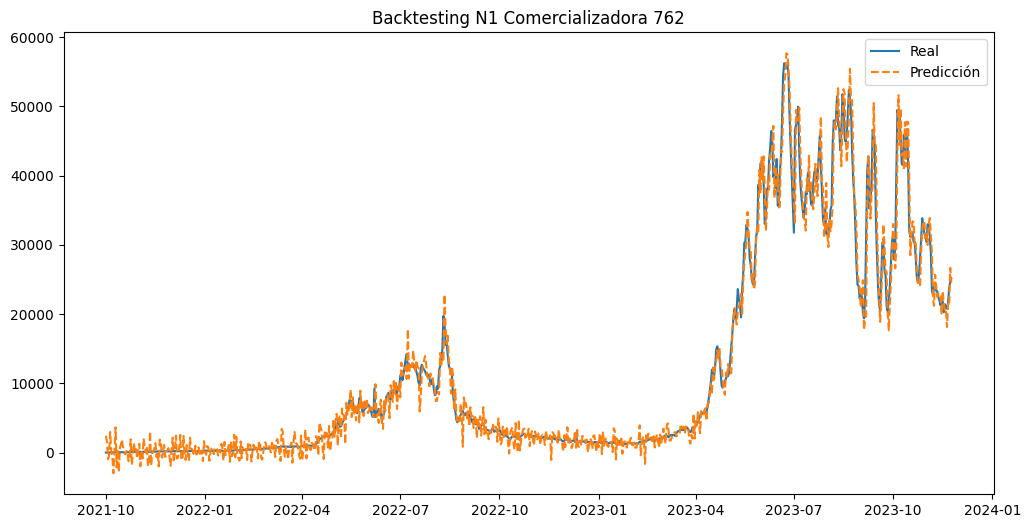

In [82]:
# Datos reales: Reparto_N1_762
reales_N1_762 = np.array(Reparto_N1_762)

# Extraer las medias de los coeficientes del posterior
beta_temp_max_N1_762 = trace.posterior['beta_762_Temp_Max'].mean().item()
beta_temp_min_N1_762 = trace.posterior['beta_762_Temp_Min'].mean().item()

# Realizar predicciones retrospectivas (backtesting)
predicciones_bayes_N1_762 = beta_temp_max_N1_762 * Temp_ponderada_Max_762 + beta_temp_min_N1_762 * Temp_ponderada_Min_762

# Calcular el residual (noise) entre datos reales y predicciones bayesianas
noise_N1_762 = reales_N1_762 - predicciones_bayes_N1_762

# Ajustar modelo ARIMA para el residual (noise)
model_N1_762_arima = ARIMA(noise_N1_762, order=(1,1,1))
model_N1_762_fit = model_N1_762_arima.fit()

# Hacer predicciones usando ARIMA sobre el residual
predicciones_arima_N1_762 = model_N1_762_fit.fittedvalues

# Predicción final combinada
predicciones_finales_N1_762 = predicciones_bayes_N1_762 + predicciones_arima_N1_762

# Calcular métricas de evaluación para el backtesting
mae_N1_762 = mean_absolute_error(reales_N1_762, predicciones_finales_N1_762)
rmse_N1_762 = np.sqrt(mean_squared_error(reales_N1_762, predicciones_finales_N1_762))

print(f"MAE N1_762: {mae_N1_762}")
print(f"RMSE N1_762: {rmse_N1_762}")

# Crear un DataFrame con los resultados
df_backtesting_N1_762 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_N1_762), freq='D'),
    'Real': reales_N1_762,
    'Prediccion': predicciones_finales_N1_762
})

# Plotear los resultados del backtesting
plt.figure(figsize=(12, 6))
plt.plot(df_backtesting_N1_762['Fecha'], df_backtesting_N1_762['Real'], label='Real')
plt.plot(df_backtesting_N1_762['Fecha'], df_backtesting_N1_762['Prediccion'], label='Predicción', linestyle='--')
plt.title('Backtesting N1 Comercializadora 762')
plt.legend()
plt.show()


In [95]:
# Crear un DataFrame con los resultados
df_backtesting_N1_762= pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_N1_762), freq='D'),
    'Real': reales_N1_762,
    'Prediccion': predicciones_finales_N1_762
})
df_backtesting_N1_762.head(5)

,Fecha,Real,Prediccion
0,2021-10-01,10.0,2437.048692
1,2021-10-02,11.0,1617.636290
2,2021-10-03,10.0,-948.665913
3,2021-10-04,16.0,-436.226146
4,2021-10-05,14.0,2987.402181
